In [1]:
# import essential libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
# Loading the data
new_data = pd.read_csv("/kaggle/input/location-separated-data/Argentina_Buenos Aires.csv")

# print the shape
print(new_data.shape)

#runs the first 5 rows
new_data.head()

(2477, 20)


,Date,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,CO_SubIndex,NO2_SubIndex,O3_SubIndex,PM10_SubIndex,PM2.5_SubIndex,SO2_SubIndex,Checks,AQI,AQI_bucket,Country_City
0,2015-04-27,3.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,34.090909,1.886792,0,2.777778,0.0,0.0,3,34.0,Good,Argentina_Buenos Aires
1,2015-04-28,61.0,45.0,NaN,65.0,NaN,NaN,NaN,NaN,NaN,500.052421,42.452830,0,55.050505,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2,2015-04-29,70.0,48.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,500.097354,45.283019,0,47.222222,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
3,2015-05-03,68.0,45.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,500.087369,42.452830,0,50.505051,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
4,2015-05-04,72.0,46.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,500.107339,43.396226,0,10.185185,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires


In [3]:
# Convert Date column to datetime
new_data['Date'] = pd.to_datetime(new_data['Date'])

# Set Date as the index
new_data.set_index('Date', inplace=True)

new_data.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,CO_SubIndex,NO2_SubIndex,O3_SubIndex,PM10_SubIndex,PM2.5_SubIndex,SO2_SubIndex,Checks,AQI,AQI_bucket,Country_City
Date,,,,,,,,,,,,,,,,,,,
2015-04-27,3.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,34.090909,1.886792,0,2.777778,0.0,0.0,3,34.0,Good,Argentina_Buenos Aires
2015-04-28,61.0,45.0,NaN,65.0,NaN,NaN,NaN,NaN,NaN,500.052421,42.452830,0,55.050505,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2015-04-29,70.0,48.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,500.097354,45.283019,0,47.222222,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2015-05-03,68.0,45.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,500.087369,42.452830,0,50.505051,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2015-05-04,72.0,46.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,500.107339,43.396226,0,10.185185,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires


# Basic LSTM 
- Using only AQI as feature
- Taking 6 previous data as input and 7th as output or level(window_size or kernal size = 6)

<Axes: xlabel='Date'>

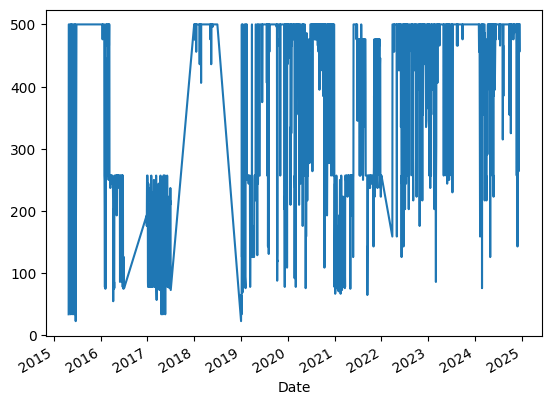

In [4]:
aqi = new_data['AQI']
aqi.plot()

In [5]:
# function to define window_size, converting data into numpy array, 
# two types of array X-feature and y-label

def new_data_to_X_y(new_data, window_size=6):
  new_data_as_np = new_data.to_numpy()
  X = []
  y = []
  for i in range(len(new_data_as_np)-window_size):
    row = [[a] for a in new_data_as_np[i:i+window_size]]
    X.append(row)
    label = new_data_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
#passing data to function

WINDOW_SIZE = 6
X1, y1 = new_data_to_X_y(aqi, WINDOW_SIZE)
X1.shape, y1.shape

((2471, 6, 1), (2471,))

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X1 = scaler.fit_transform(X1.reshape(-1, 6)).reshape(-1, 6, 1)

In [8]:
# train,validation, and test split

X_train1, y_train1 = X1[:1200], y1[:1200]
X_val1, y_val1 = X1[1200:2000], y1[1200:2000]
X_test1, y_test1 = X1[2000:], y1[2000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1200, 6, 1), (1200,), (800, 6, 1), (800,), (471, 6, 1), (471,))

In [9]:
# libraries for building model and testing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [10]:
model1 = Sequential()
model1.add(InputLayer((6, 1))) # 6 timestamp , 1 feature
model1.add(LSTM(32)) # LSTM layer with 16 units
model1.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001))) # activation function- ReLU with 8 dense layer
model1.add(Dense(1, 'linear')) # output - linear and data- 1

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,625 (18.07 KB)

 Trainable params: 4,625 (18.07 KB)

 Non-trainable params: 0 (0.00 B)

**saving best performing model**

**configuring the model:** 
Loss: To measure how far the predictions are from actual values.
Optimizer: To adjust model weights and minimize the loss.
Metrics: To monitor performance during training.

In [11]:
cp1 = ModelCheckpoint('/kaggle/working/model1.keras', save_best_only=True)

model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), 
               metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp1])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 156914.5156 - root_mean_squared_error: 396.1157 - val_loss: 153088.5469 - val_root_mean_squared_error: 391.2653
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 136061.9844 - root_mean_squared_error: 368.7586 - val_loss: 111685.5625 - val_root_mean_squared_error: 334.1938
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 90364.7188 - root_mean_squared_error: 300.5533 - val_loss: 63821.6836 - val_root_mean_squared_error: 252.6292
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51904.0625 - root_mean_squared_error: 227.6650 - val_loss: 30720.5977 - val_root_mean_squared_error: 175.2722
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30529.3867 - root_mean_squared_error: 174.6731 - val_loss: 20306.4629 - val_root_mean_squared_error: 142.4997
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24469.1738 - root_mean_squared_error: 156.3759 - val_loss: 18560.6074 - val_root_mean_squar

A massive underfitting even changing parameters has no impact on it

In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/model1.keras')

In [14]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Train Predictions,Actuals
0,465.270386,500.0
1,486.995209,500.0
2,486.995209,500.0
3,486.995209,500.0
4,486.995209,34.0
...,...,...
1195,486.091736,500.0
1196,486.062927,500.0
1197,486.995209,476.0
1198,479.080261,500.0


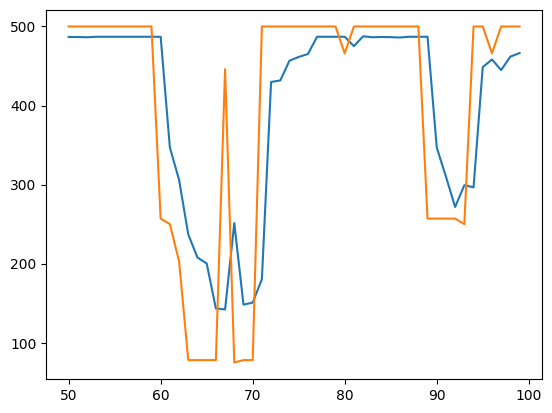

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [16]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Val Predictions,Actuals
0,478.564819,500.0
1,487.172913,476.0
2,478.167542,426.0
3,453.556213,500.0
4,487.346680,486.0
...,...,...
795,486.995209,500.0
796,486.995209,500.0
797,486.995209,257.0
798,346.916138,500.0


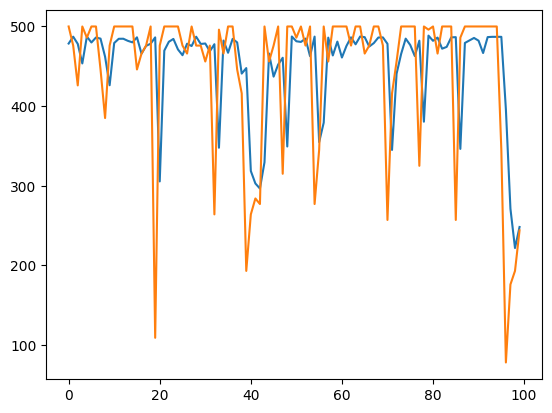

In [17]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [18]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Test Predictions,Actuals
0,482.300354,500.0
1,485.888245,500.0
2,482.622498,500.0
3,467.556091,500.0
4,486.995209,500.0
...,...,...
466,286.975952,500.0
467,479.626617,500.0
468,470.824646,500.0
469,461.682220,456.0


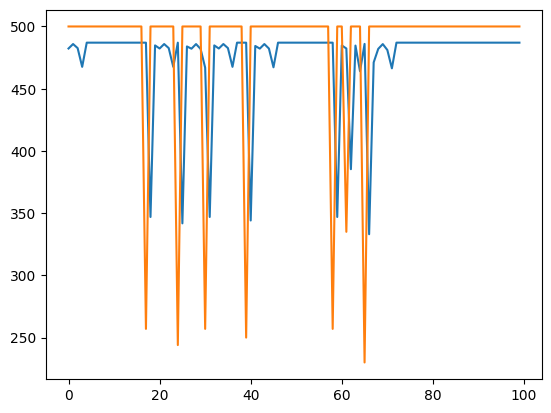

In [19]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

**CNN(1D)**

In [20]:
model2 = Sequential()
model2.add(InputLayer((6, 1)))
model2.add(Conv1D(32, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 5, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           1,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,393 (5.44 KB)

 Trainable params: 1,393 (5.44 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cp2 = ModelCheckpoint('/kaggle/working/model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [22]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 157835.5625 - root_mean_squared_error: 397.2183 - val_loss: 152867.7344 - val_root_mean_squared_error: 390.9830
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 133355.7188 - root_mean_squared_error: 365.0388 - val_loss: 47674.2812 - val_root_mean_squared_error: 218.3444
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22693.2520 - root_mean_squared_error: 147.3911 - val_loss: 7777.6338 - val_root_mean_squared_error: 88.1909
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8213.7021 - root_mean_squared_error: 90.5399 - val_loss: 6942.1831 - val_root_mean_squared_error: 83.3198
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7435.1035 - root_mean_squared_error: 86.0706 - val_loss: 6724.8438 - val_root_mean_squared_error: 82.0051
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7263.3477 - root_mean_squared_error: 84.9154 - val_loss: 6533.2524 - val_root_mean_squared_error: 80.82

**GRU**

In [23]:
model3 = Sequential()
model3.add(InputLayer((6, 1)))
model3.add(GRU(32))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,633 (14.19 KB)

 Trainable params: 3,633 (14.19 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cp3 = ModelCheckpoint('/kaggle/working/model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [25]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp3])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 156280.9062 - root_mean_squared_error: 395.3036 - val_loss: 142919.5625 - val_root_mean_squared_error: 378.0470
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 123464.3359 - root_mean_squared_error: 351.1175 - val_loss: 88232.9922 - val_root_mean_squared_error: 297.0404
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 70039.2109 - root_mean_squared_error: 264.3779 - val_loss: 37922.1367 - val_root_mean_squared_error: 194.7361
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34091.3398 - root_mean_squared_error: 184.4860 - val_loss: 20347.0781 - val_root_mean_squared_error: 142.6432
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24762.0000 - root_mean_squared_error: 157.3514 - val_loss: 18519.9688 - val_root_mean_squared_error: 136.0881
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26379.4043 - root_mean_squared_error: 162.3234 - val_loss: 18318.5254 - val_root_mean_square

**RNN**

In [26]:
model4 = Sequential()
model4.add(InputLayer((6, 1)))
model4.add(SimpleRNN(32))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,361 (5.32 KB)

 Trainable params: 1,361 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
cp4 = ModelCheckpoint('/kaggle/working/model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [28]:
model4.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp4])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 157084.3594 - root_mean_squared_error: 396.3185 - val_loss: 150685.3438 - val_root_mean_squared_error: 388.1821
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 137423.2500 - root_mean_squared_error: 370.6016 - val_loss: 131934.7031 - val_root_mean_squared_error: 363.2282
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 118270.4844 - root_mean_squared_error: 343.7217 - val_loss: 95036.4297 - val_root_mean_squared_error: 308.2798
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79665.1172 - root_mean_squared_error: 282.0897 - val_loss: 60147.1289 - val_root_mean_squared_error: 245.2491
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51532.1406 - root_mean_squared_error: 226.8961 - val_loss: 35795.1016 - val_root_mean_squared_error: 189.1959
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35059.2734 - root_mean_squared_error: 187.1573 - val_loss: 23954.7266 - val_root_mean_squa

Multiple Feature to Predict AQI

In [29]:
aqi2 = new_data.copy()
aqi2.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,CO_SubIndex,NO2_SubIndex,O3_SubIndex,PM10_SubIndex,PM2.5_SubIndex,SO2_SubIndex,Checks,AQI,AQI_bucket,Country_City
Date,,,,,,,,,,,,,,,,,,,
2015-04-27,3.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,34.090909,1.886792,0,2.777778,0.0,0.0,3,34.0,Good,Argentina_Buenos Aires
2015-04-28,61.0,45.0,NaN,65.0,NaN,NaN,NaN,NaN,NaN,500.052421,42.452830,0,55.050505,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2015-04-29,70.0,48.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,500.097354,45.283019,0,47.222222,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2015-05-03,68.0,45.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,500.087369,42.452830,0,50.505051,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires
2015-05-04,72.0,46.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,500.107339,43.396226,0,10.185185,0.0,0.0,3,500.0,Hazardous,Argentina_Buenos Aires


In [30]:
aqi2.columns

Index(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
       'temperature', 'CO_SubIndex', 'NO2_SubIndex', 'O3_SubIndex',
       'PM10_SubIndex', 'PM2.5_SubIndex', 'SO2_SubIndex', 'Checks', 'AQI',
       'AQI_bucket', 'Country_City'],
      dtype='object')

In [31]:
aqi2 = aqi2.drop(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
                  'temperature', 'Checks', 'AQI_bucket', 'Country_City'], axis=1)

In [32]:
aqi2.head()

,CO_SubIndex,NO2_SubIndex,O3_SubIndex,PM10_SubIndex,PM2.5_SubIndex,SO2_SubIndex,AQI
Date,,,,,,,
2015-04-27,34.090909,1.886792,0,2.777778,0.0,0.0,34.0
2015-04-28,500.052421,42.452830,0,55.050505,0.0,0.0,500.0
2015-04-29,500.097354,45.283019,0,47.222222,0.0,0.0,500.0
2015-05-03,500.087369,42.452830,0,50.505051,0.0,0.0,500.0
2015-05-04,500.107339,43.396226,0,10.185185,0.0,0.0,500.0


In [33]:
for column in aqi2:
    unique_vals = np.unique(aqi2[column])  # numpy unique for numerical types

    nr_values = len(unique_vals)
    if nr_values < 14:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature CO_SubIndex :96
The number of values for feature NO2_SubIndex :63
The number of values for feature O3_SubIndex :1 -- [0]
The number of values for feature PM10_SubIndex :95
The number of values for feature PM2.5_SubIndex :48
The number of values for feature SO2_SubIndex :24
The number of values for feature AQI :63


In [34]:
# function to define window_size, converting data into numpy array, 
# two types of array X-feature and y-label

def new_data_to_X_y_2(new_data, window_size=6):
    new_data_as_np = new_data.to_numpy()
    X = []
    y = []
    for i in range(len(new_data_as_np) - window_size):
        row = new_data_as_np[i:i+window_size]  
        X.append(row)
        label = new_data_as_np[i+window_size, -1] 
        y.append(label)
    return np.array(X), np.array(y)

In [35]:
#passing data to function

WINDOW_SIZE = 6
X1, y1 = new_data_to_X_y_2(aqi2, WINDOW_SIZE)
X1.shape, y1.shape

((2471, 6, 7), (2471,))

In [36]:
# train,validation, and test split

X_train1, y_train1 = X1[:1200], y1[:1200]
X_val1, y_val1 = X1[1200:2000], y1[1200:2000]
X_test1, y_test1 = X1[2000:], y1[2000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1200, 6, 7), (1200,), (800, 6, 7), (800,), (471, 6, 7), (471,))

In [37]:
model5 = Sequential()
model5.add(InputLayer((6, 7))) # 6 timestamp , 1 feature
model5.add(LSTM(32)) # LSTM layer with 16 units
model5.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001))) # activation function- ReLU with 8 dense layer
model5.add(Dense(1, 'linear')) # output - linear and data- 1

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,393 (21.07 KB)

 Trainable params: 5,393 (21.07 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
cp5 = ModelCheckpoint('/kaggle/working/model5.keras', save_best_only=True)

model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), 
               metrics=[RootMeanSquaredError()])

In [39]:
model5.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp5])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 160589.6562 - root_mean_squared_error: 400.5958 - val_loss: 147360.5312 - val_root_mean_squared_error: 383.8756
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 124441.2031 - root_mean_squared_error: 352.5666 - val_loss: 82599.8281 - val_root_mean_squared_error: 287.4017
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 60083.2266 - root_mean_squared_error: 244.9044 - val_loss: 29992.9043 - val_root_mean_squared_error: 173.1840
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29649.1133 - root_mean_squared_error: 172.0057 - val_loss: 18293.8711 - val_root_mean_squared_error: 135.2538
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22944.2012 - root_mean_squared_error: 151.4593 - val_loss: 16183.0264 - val_root_mean_squared_error: 127.2113
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20226.7520 - root_mean_squared_error: 142.0883 - val_loss: 14097.2959 - val_root_mean_square